In [85]:
# %%
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import scipy

In [ ]:
# %%
class Line_GS_Solver(object):
    def __init__(self, num_pts):
        self.x = np.linspace(0,1,num=num_pts)
        self.grid = np.stack(np.meshgrid(self.x,self.x,indexing='ij'))  # 2 x num_pts x num_pts
        self.num_pts = num_pts
        self.delta = self.x[1]-self.x[0]

    def find_boundary(self, boundary_list):
        mask = np.zeros((self.num_pts, self.num_pts), dtype=np.bool)

        for boundary in boundary_list:
            
            center = boundary[:-1]
            radius = boundary[-1]
            mask = np.logical_or(mask, np.sum((self.grid - center[:, None, None])**2, axis=0) <= radius**2)

        return mask
    
    def solve(self, boundary_list, w=1.0, max_iter=100, verbose=True):
        np.random.seed(0)
        u = np.random.uniform(-1, 1, (self.num_pts, self.num_pts))
        
        inner_boundary = self.find_boundary(boundary_list)
        
        # Create total fixed mask (obstacles + outer frame)
        whole_boundary = np.copy(inner_boundary)
        whole_boundary[0, :] = True   # Bottom
        whole_boundary[-1, :] = True  # Top
        whole_boundary[:, 0] = True   # Left
        whole_boundary[:, -1] = True  # Right
        
        # Set boundary values
        u[whole_boundary] = 0
        u[inner_boundary] = 1
        
        for _ in tqdm(range(max_iter), disable=not verbose):
            for row in range(1, self.num_pts - 1):
                # Find unknown positions in this row
                mask = whole_boundary[row, 1:-1]
                unknown_indices = np.where(~mask)[0]
                n_unknowns = len(unknown_indices)
                
                if n_unknowns == 0:
                    continue  # entire row is boundary
                
                # Build tridiagonal matrix for this row
                A = np.zeros((n_unknowns, n_unknowns))
                np.fill_diagonal(A, -4)
                
                # Off-diagonals: only connect consecutive unknowns
                for idx in range(n_unknowns - 1):
                    if unknown_indices[idx + 1] == unknown_indices[idx] + 1:
                        A[idx, idx + 1] = 1
                        A[idx + 1, idx] = 1
                
                # Build RHS
                rhs = np.zeros(n_unknowns)
                for idx, j_local in enumerate(unknown_indices):
                    j = j_local + 1  # adjust for the 1:-1 slicing
                    
                    # Contributions from horizontal neighbors (other rows)
                    rhs[idx] -= u[row - 1, j]  # top neighbor
                    rhs[idx] -= u[row + 1, j]  # bottom neighbor
                    
                    # Contributions from vertical neighbors (same row)
                    # Left neighbor (j-1)
                    if whole_boundary[row, j - 1]:
                        rhs[idx] -= u[row, j - 1]  # boundary value
                    # else: handled by matrix A
                    
                    # Right neighbor (j+1)
                    if whole_boundary[row, j + 1]:
                        rhs[idx] -= u[row, j + 1]  # boundary value
                    # else: handled by matrix A
                
                # Solve the system
                x = scipy.linalg.solve(A,rhs,assume_a='banded')
                
                # Update unknowns
                u[row, 1:-1][~mask] = (1-w)*u[row, 1:-1][~mask]+w*x
        
        return u
    
    def get_residual(self,solution,boundary,sum=True):

        solution = torch.tensor(solution,dtype=torch.float64)
        conv_weight=torch.tensor([
            [0,1,0],
            [1,-4,1],
            [0,1,0]
        ],dtype=torch.float64).unsqueeze(0).unsqueeze(0)

        res=F.conv2d(solution[None,None,:,:],conv_weight)/self.delta**2
        res=F.pad(res,pad=[1,1,1,1],mode='constant',value=0)

        res *= ~torch.tensor(boundary, dtype=torch.bool)

        if sum:
            return F.mse_loss(res,torch.zeros_like(res))

        else:
            return res.squeeze()

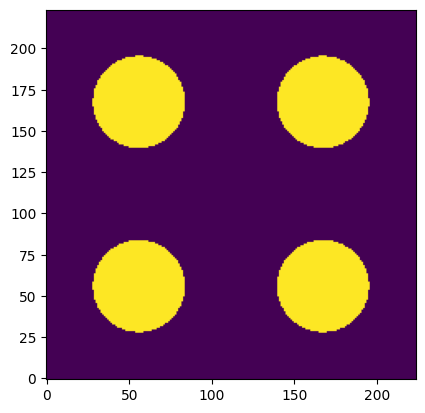

100%|██████████| 1000/1000 [00:35<00:00, 28.20it/s]


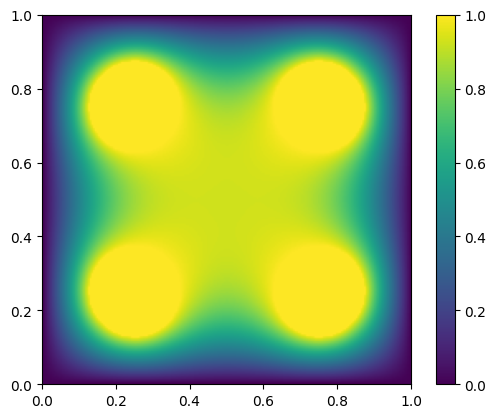

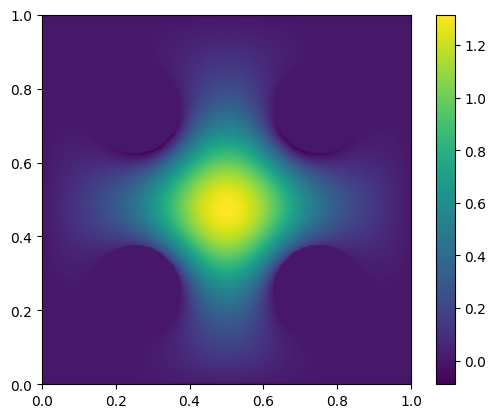

In [87]:
solver = Line_GS_Solver(num_pts=224)
boundary_list = np.array(
    # [[0.5,0.5,0.25]]
    [[0.25,0.25,0.125],
        [0.25,0.75,0.125],
        [0.75,0.25,0.125],
        [0.75,0.75,0.125]]
    )
mask = solver.find_boundary(boundary_list)
plt.imshow(mask,origin='lower')
plt.show()

solution = solver.solve(boundary_list, w=1.5, max_iter=1000)
plt.imshow(solution.squeeze(),origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.show()
plt.imshow(solver.get_residual(solution,mask,sum=False),origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.show()